In [1]:
from tqdm import tqdm
import numpy as np

In [14]:
# so, we have near-equilibrium results all in one place:
from pickle import load
from simtk import unit

with open('result_summary.pkl', 'rb') as f:
    near_eq_result_summary = load(f)
    
# and nested-MC estimates in two places:

# (1) the samples collected in parallel for dt >= 5fs
from glob import glob
fnames = glob('../data/tight_tolerance_results_parallel_5x/summary_*.pkl')
results = []
for fname in fnames:
    with open(fname, 'rb') as f:
        results.append(load(f))

parallel_descriptions = [r[0] for r in results]        

# (2) the samples collected serially for small dt
pkls = glob('../data/water_cluster_rigid_3/*.pkl')

for fname in pkls:
    with open(fname, 'rb') as f:
        result = load(f)
        
    if result[0] not in parallel_descriptions:
        results.append(result)
    else:
        print('discarding prior result for {}-{}fs'.format(result[0][0], result[0][1] / unit.femtosecond))
print(len(results))

discarding prior result for ORVRO-6.5fs
discarding prior result for ORVRO-6.0fs
discarding prior result for ORVRO-6.5fs
discarding prior result for RVOVR-5.0fs
discarding prior result for ORVRO-7.0fs
discarding prior result for ORVRO-8.0fs
discarding prior result for RVOVR-7.0fs
discarding prior result for RVOVR-7.5fs
discarding prior result for ORVRO-7.5fs
discarding prior result for ORVRO-7.0fs
discarding prior result for ORVRO-5.5fs
discarding prior result for ORVRO-6.0fs
discarding prior result for ORVRO-7.5fs
discarding prior result for RVOVR-8.0fs
discarding prior result for OVRVO-7.0fs
discarding prior result for RVOVR-7.5fs
discarding prior result for VRORV-6.0fs
discarding prior result for VRORV-6.5fs
discarding prior result for RVOVR-8.0fs
discarding prior result for OVRVO-6.5fs
discarding prior result for OVRVO-5.5fs
discarding prior result for VRORV-8.0fs
discarding prior result for VRORV-5.0fs
discarding prior result for OVRVO-5.0fs
discarding prior result for OVRVO-8.0fs


In [16]:
with open('result_summary.pkl', 'rb') as f:
    near_eq_result_summary = load(f)
    
def get_near_eq_curves_with_unc(scheme, marginal):
    r = near_eq_result_summary[scheme][marginal]
    return r['dts'], r['near_eq_estimates'], r['near_eq_uncertainty']

dts, near_eq, near_eq_unc = get_near_eq_curves_with_unc('OVRVO', 'full')
dts[-2], near_eq[-2], near_eq_unc[-2]

(7.5, 0.46480117643448038, 0.013365315464762656)

In [17]:
def estimate_from_work_samples(work_samples):
    """Returns an estimate of log(rho(x) / pi(x)) from unitless work_samples initialized at x"""
    return np.log(np.mean(np.exp(-np.array(work_samples))))

In [18]:
def get_mean_unc(result):
    Ws = result[1]['Ws']
    log_rho_pis = np.array(list(map(estimate_from_work_samples, Ws)))
    finite_log_rho_pis = log_rho_pis[np.isfinite(log_rho_pis)]
    N = len(finite_log_rho_pis)
    mean = np.mean(finite_log_rho_pis)
    unc = np.std(finite_log_rho_pis) / np.sqrt(N)
    return mean, unc

In [19]:
import seaborn.apionly as sns
schemes = sorted(['RVOVR', 'VRORV', 'OVRVO', 'ORVRO'])
color_schemes = dict(zip(schemes, ['Blues', 'Greens', 'Oranges', 'Purples']))

colormaps = dict()


for scheme in schemes:
    colormap = sns.color_palette(color_schemes[scheme], n_colors=len(dts))
    colormaps[scheme] = dict(zip(dts, colormap))

    
full_depth_colors = dict()
for scheme in schemes:
    full_depth_colors[scheme] = colormaps[scheme][max(dts)]

dt_ = dts[int(len(dts)/2)]
colors = dict()
for scheme in schemes:
    colors[scheme] = colormaps[scheme][dt_]
    
half_depth_colors = colors

In [20]:
dts

array([ 0.1,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ])

In [21]:
from simtk import unit

In [22]:
near_eq = []
near_eq_unc = []

nested = []
nested_unc = []

c = []

for result in results:
    
    scheme, dt_unitd, marginal, testsystem = result[0]
    dt = dt_unitd / unit.femtosecond
    
    
    # near-eq
    dts, mean, unc = get_near_eq_curves_with_unc(scheme, marginal)
    ind = np.argmin(np.abs(dts - dt))
    near_eq.append(mean[ind])
    near_eq_unc.append(1.96 * unc[ind])
    
    # nested
    mean, unc = get_mean_unc(result)
    nested.append(mean)
    nested_unc.append(1.96 * unc)
    
    c.append(colors[scheme])

In [23]:
problematic_cases = []
for result in results:
    if max([len(w) for w in result[1]['Ws']]) == 50000:
        print(result[0])
        problematic_cases.append(result[0])

('OVRVO', Quantity(value=8.0, unit=femtosecond), 'full', 'water_cluster_rigid')
('OVRVO', Quantity(value=7.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')
('OVRVO', Quantity(value=7.5, unit=femtosecond), 'full', 'water_cluster_rigid')
('VRORV', Quantity(value=8.0, unit=femtosecond), 'full', 'water_cluster_rigid')
('VRORV', Quantity(value=7.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')
('OVRVO', Quantity(value=8.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')
('VRORV', Quantity(value=8.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')
('RVOVR', Quantity(value=7.5, unit=femtosecond), 'full', 'water_cluster_rigid')
('RVOVR', Quantity(value=7.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')
('OVRVO', Quantity(value=7.0, unit=femtosecond), 'full', 'water_cluster_rigid')
('RVOVR', Quantity(value=8.0, unit=femtosecond), 'full', 'water_cluster_rigid')
('VRORV', Quantity(value=7.5, unit=femtosecond), 'configuration', 'water_cl

In [24]:
def stdev_log_rho_pi(w):
    """Approximate the standard deviation of the estimate of log < e^{-w} >_{x; \Lambda}

    Parameters
    ----------
    w : unitless (kT) numpy array of work samples

    Returns
    -------
    stdev : float

    Notes
    -----
    This will be an underestimate esp. when len(w) is small or stdev_log_rho_pi is large.
    """

    assert(type(w) != unit.Quantity) # assert w is unitless
    assert(type(w) == np.ndarray) # assert w is a numpy array

    # use leading term in taylor expansion: anecdotally, looks like it's in good agreement with
    # bootstrapped uncertainty estimates up to ~0.5-0.75, then becomes an increasingly bad underestimate
    return np.std(np.exp(-w)) / (np.mean(np.exp(-w)) * np.sqrt(len(w)))

In [34]:
problematic_cases = []
for result in results:
    if max([len(w) for w in result[1]['Ws']]) == 50000:
        print(result[0])
        problematic_cases.append((result[0], list(map(stdev_log_rho_pi, [w for w in result[1]['Ws']]))))

('OVRVO', Quantity(value=8.0, unit=femtosecond), 'full', 'water_cluster_rigid')
('OVRVO', Quantity(value=7.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')
('OVRVO', Quantity(value=7.5, unit=femtosecond), 'full', 'water_cluster_rigid')
('VRORV', Quantity(value=8.0, unit=femtosecond), 'full', 'water_cluster_rigid')
('VRORV', Quantity(value=7.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')
('OVRVO', Quantity(value=8.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')
('VRORV', Quantity(value=8.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')
('RVOVR', Quantity(value=7.5, unit=femtosecond), 'full', 'water_cluster_rigid')
('RVOVR', Quantity(value=7.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')
('OVRVO', Quantity(value=7.0, unit=femtosecond), 'full', 'water_cluster_rigid')
('RVOVR', Quantity(value=8.0, unit=femtosecond), 'full', 'water_cluster_rigid')
('VRORV', Quantity(value=7.5, unit=femtosecond), 'configuration', 'water_cl

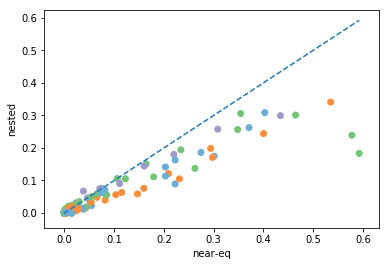

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(near_eq, nested, c=c)

x = np.linspace(min(near_eq), max(near_eq))
plt.plot(x, x, '--')
plt.xlabel('near-eq')
plt.ylabel('nested')

In [36]:
len(problematic_cases)

18

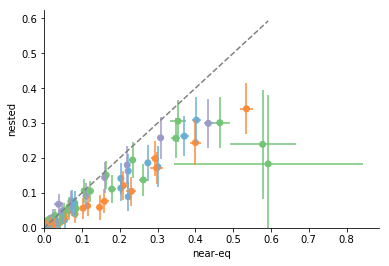

In [37]:
ax = plt.subplot(1,1,1)
plt.scatter(near_eq, nested, c=c)
plt.errorbar(near_eq, nested, xerr=near_eq_unc, yerr=nested_unc, fmt='none', c=c)

x = np.linspace(min(near_eq), max(near_eq))
plt.plot(x, x, '--', color='grey')
plt.xlabel('near-eq')
plt.ylabel('nested')
plt.xlim(0,)
plt.ylim(0,)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [42]:
# let's re-do the scatter plot, but omit the conditions that had any outer-loop samples that didn't meet the 0.01kT threshold...


near_eq = []
near_eq_unc = []

nested = []
nested_unc = []

c = []

for result in results:
    
    if max([len(w) for w in result[1]['Ws']]) == 50000:
        print("skipping {}!".format(result[0]))
        continue
    
    scheme, dt_unitd, marginal, testsystem = result[0]
    dt = dt_unitd / unit.femtosecond
    
    
    # near-eq
    dts, mean, unc = get_near_eq_curves_with_unc(scheme, marginal)
    ind = np.argmin(np.abs(dts - dt))
    near_eq.append(mean[ind])
    near_eq_unc.append(1.96 * unc[ind])
    
    # nested
    mean, unc = get_mean_unc(result)
    nested.append(mean)
    nested_unc.append(1.96 * unc)
    
    c.append(colors[scheme])    

skipping ('OVRVO', Quantity(value=8.0, unit=femtosecond), 'full', 'water_cluster_rigid')!
skipping ('OVRVO', Quantity(value=7.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')!
skipping ('OVRVO', Quantity(value=7.5, unit=femtosecond), 'full', 'water_cluster_rigid')!
skipping ('VRORV', Quantity(value=8.0, unit=femtosecond), 'full', 'water_cluster_rigid')!
skipping ('VRORV', Quantity(value=7.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')!
skipping ('OVRVO', Quantity(value=8.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')!
skipping ('VRORV', Quantity(value=8.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')!
skipping ('RVOVR', Quantity(value=7.5, unit=femtosecond), 'full', 'water_cluster_rigid')!
skipping ('RVOVR', Quantity(value=7.0, unit=femtosecond), 'configuration', 'water_cluster_rigid')!
skipping ('OVRVO', Quantity(value=7.0, unit=femtosecond), 'full', 'water_cluster_rigid')!
skipping ('RVOVR', Quantity(value=8.0, unit=femtosecond

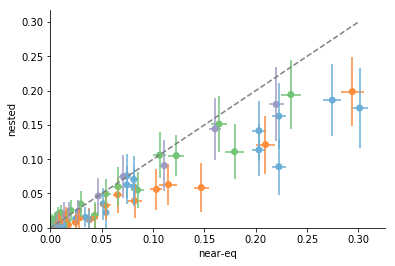

In [43]:
ax = plt.subplot(1,1,1)
plt.scatter(near_eq, nested, c=c)
plt.errorbar(near_eq, nested, xerr=near_eq_unc, yerr=nested_unc, fmt='none', c=c)

x = np.linspace(min(near_eq), max(near_eq))
plt.plot(x, x, '--', color='grey')
plt.xlabel('near-eq')
plt.ylabel('nested')
plt.xlim(0,)
plt.ylim(0,)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [71]:
# let's re-do the scatter plot, but omit the conditions that had any outer-loop samples that didn't meet the 0.01kT threshold...


near_eq = []
near_eq_unc = []

nested = []
nested_unc = []

c = []

for result in results:

    scheme, dt_unitd, marginal, testsystem = result[0]
    dt = dt_unitd / unit.femtosecond
    
    
    # near-eq
    dts, mean, unc = get_near_eq_curves_with_unc(scheme, marginal)
    ind = np.argmin(np.abs(dts - dt))
    near_eq.append(mean[ind])
    near_eq_unc.append(1.96 * unc[ind])
    
    # nested
    mean, unc = get_mean_unc(result)
    nested.append(mean)
    nested_unc.append(1.96 * unc)
    
    if max([len(w) for w in result[1]['Ws']]) == 50000:

    
        c.append('lightgrey')   
    else:
        c.append(colors[scheme])   

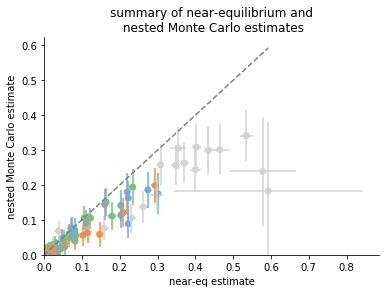

In [72]:
ax = plt.subplot(1,1,1)
plt.scatter(near_eq, nested, c=c)
plt.errorbar(near_eq, nested, xerr=near_eq_unc, yerr=nested_unc, fmt='none', c=c)

x = np.linspace(min(near_eq), max(near_eq))
plt.plot(x, x, '--', color='grey')
plt.xlabel('near-eq estimate')
plt.ylabel('nested Monte Carlo estimate')
plt.xlim(0,)
plt.ylim(0,)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('summary of near-equilibrium and\n nested Monte Carlo estimates')
plt.savefig('near_eq_vs_exact_summary.pdf')

In [46]:
from benchmark.evaluation.compare_near_eq_and_exact import resample_Ws, process_outer_samples, estimate_from_work_samples
from tqdm import tqdm
n_bootstrap_samples = 100

means_new, stdevs_new = [], []

for result in tqdm(results):
    Ws = result[1]['Ws']
    samples_new = []
    #means_new.append(np.mean([estimate_from_work_samples(w) for w in Ws]))
    
    for _ in range(n_bootstrap_samples):
        Ws_ = resample_Ws(Ws)
        new_estimate = np.mean([estimate_from_work_samples(w) for w in Ws_])
        
        samples_new.append(new_estimate)
    
    means_new.append(np.mean(samples_new))
    stdevs_new.append(np.std(samples_new))

means_new = np.array(means_new)
stdevs_new = np.array(stdevs_new)

/Users/joshuafass/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


OpenMM version:  7.2.0.dev-fb607c7
OpenMM version:  7.2.0.dev-fb607c7
	Removing CMMotionRemover
	Removing CMMotionRemover
Desired platform not supported
Desired platform not supported
Desired platform not supported
Desired platform not supported
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported


100%|██████████| 136/136 [28:34<00:00,  1.78s/it] 


In [48]:
def get_curves_with_unc(scheme='RVOVR', marginal='configuration'):
    dts = []

    
    new_estimates = []
    new_estimates_unc = []
    
    for i, (descr, _) in enumerate(results):
        if descr[0] == scheme and descr[2] == marginal:
            dts.append(descr[1].value_in_unit(unit.femtosecond))
            
            new_estimates.append(means_new[i])

            new_estimates_unc.append(stdevs_new[i])
    
    inds = np.argsort(dts)
    sort_by_dt = lambda l : np.array(l)[inds]
    return list(map(sort_by_dt, [dts, new_estimates, new_estimates_unc]))

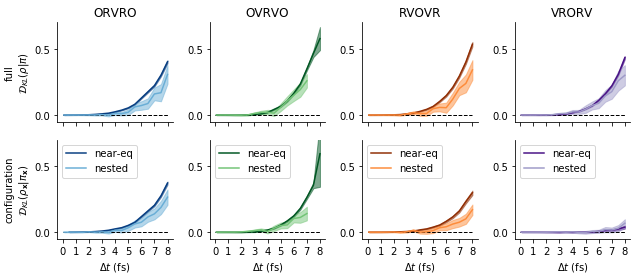

In [50]:
def new_figure():
    plt.figure(figsize=(8,8))

    
def remove_upper_right_spines(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
def plot_marginal(marginal='configuration', start_subplot=1, use_near_eq_summary=True):
        
    for i, scheme in enumerate(schemes):
        near_eq_color = full_depth_colors[scheme]
        exact_color = half_depth_colors[scheme]
        
        dts, new_estimates, new_estimates_unc = get_curves_with_unc(scheme, marginal)
        dts_near_eq = dts
    
        
        if i == 0:
            ax_0 = plt.subplot(2,4,i+start_subplot)
            remove_upper_right_spines(ax_0)
        else:
            ax = plt.subplot(2,4,i+start_subplot,sharey=ax_0, sharex=ax_0)
            remove_upper_right_spines(ax)
        
        plt.title(scheme)
        
        if use_near_eq_summary:
            dts_near_eq, near_eq_estimates, near_eq_unc = get_near_eq_curves_with_unc(scheme, marginal)
        
        plt.plot(dts_near_eq, near_eq_estimates, color=near_eq_color, label='near-eq')
        plt.fill_between(dts_near_eq, near_eq_estimates - 1.96 * near_eq_unc, near_eq_estimates + 1.96 * near_eq_unc, color=near_eq_color, alpha=0.5)
        
        plt.plot(dts, new_estimates, color=exact_color, label='nested')
        plt.fill_between(dts, new_estimates - 1.96 * new_estimates_unc, new_estimates + 1.96 * new_estimates_unc, color=exact_color, alpha=0.5)
        
        
        if marginal == 'configuration':
            plt.ylabel('configuration\n' + r'$\mathcal{D}_{KL}(\rho_\mathbf{x} \| \pi_\mathbf{x})$')
        else:
            plt.ylabel('full\n' +r'$\mathcal{D}_{KL}(\rho \| \pi)$')
        
        xticks = list(range(0,1 + int(max(max(dts), max(dts_near_eq)))))
        
        if start_subplot == 5:
            plt.xticks(xticks)
            plt.xlabel(r'$\Delta t$ (fs)')
            plt.title('')
        else:
            plt.xticks(xticks, ['']*len(xticks))
            
        plt.hlines(0, 0, max(xticks), linewidths=1, linestyles='--', colors='k')
        
        if i  > 0:
            plt.ylabel('')
            #plt.yticks([])
        
        if start_subplot == 5:
            plt.legend(loc='upper left')

        plt.ylim(-0.05,0.7)
        plt.yticks([0,0.5])
plt.figure(figsize=(9,4))
plot_marginal('full')
plot_marginal('configuration', start_subplot=5)

plt.tight_layout()
plt.savefig('key_comparison_figure_draft_5x.jpg', dpi=300, bbox_inches='tight')